## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import skvideo.io
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [116]:
import calibration
import image_threshold
import perspetive_transform
import find_lane_pixels
import measure_curvature
import utils

In [3]:
from moviepy.editor import VideoFileClip

In [4]:
from PIL import Image, ImageFont, ImageDraw

## perspective transform

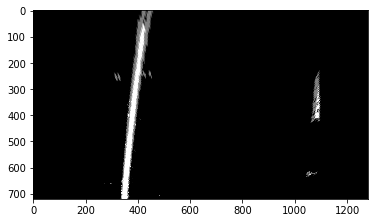

In [168]:
image = mpimg.imread('test_images/test6.jpg')
image = calibration.calibrate(image)
image = image_threshold.convert_thresh(image)

masked_image = perspetive_transform.apply_mask(image)
warped, _ = perspetive_transform.apply_perspective_transform(masked_image)

plt.imshow(warped, cmap='gray')

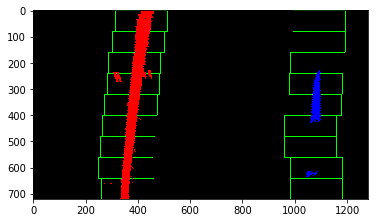

In [169]:
out_img, left_fit, right_fit = find_lane_pixels.fit_polynomial(warped)

plt.imshow(out_img)

In [110]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped, left_fit, right_fit)

# View your output
# plt.imshow(result)

In [126]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature.measure_curvature_real(left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

5269.065666416665 m 7166.129099136907 m


In [220]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
#         self.detected = False  
        # x values of the last n fits of the line
#         self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
#         self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
#         self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
#         self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
#         self.allx = None  
        #y values for detected line pixels
#         self.ally = None  

In [31]:
fontsize = 30
font = ImageFont.truetype("./Caviar-Dreams/CaviarDreams.ttf", fontsize)

In [221]:
first = True
left_line = None
right_line = None
mid_point = None
count = 0
    
def init():
    global first
    global left_line
    global right_line
    global mid_point
    global count
    first = True
    left_line = None
    right_line = None
    mid_point = None
    count = 0

In [222]:
def process_frame(frame):
    try:
        global first
        global left_line
        global right_line
        
        global font
        global fontsize
        global mid_point
        global count
        image = calibration.calibrate(frame)

        image = image_threshold.convert_thresh(image)

        h , w = image.shape

        masked_image = perspetive_transform.apply_mask(image)
        warped, M = perspetive_transform.apply_perspective_transform(masked_image)

        count += 1
        
        if first:
            result, left_fit, right_fit = find_lane_pixels.fit_polynomial(warped)
            left_line = Line()
            left_line.current_fit = left_fit
            right_line = Line()
            right_line.current_fit = right_fit
            first = False
            
            left_line.best_fit = [left_fit]
            right_line.best_fit = [right_fit]


            left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped, left_line.current_fit, right_line.current_fit)

            left_point = left_fit[0]*(720**2) + left_fit[1]*720 + left_fit[2]
            right_point = right_fit[0]*(720**2) + right_fit[1]*720 + right_fit[2]
            mid_point = right_point - left_point
            

        else:
            
            if count % 5 == 0:
                result, left_fit, right_fit = find_lane_pixels.fit_polynomial(warped)
                left_line.current_fit = left_fit
                right_line.current_fit = right_fit

                left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped,\
                                                                            left_fit,\
                                                                            right_fit)

                left_point = left_fit[0]*(720**2) + left_fit[1]*720 + left_fit[2]
                right_point = right_fit[0]*(720**2) + right_fit[1]*720 + right_fit[2]
                new_mid_point = right_point - left_point

    #             print(new_mid_point)

    #             print(left_curverad_1, right_curverad_1)
                good_fit = True
                mid = 500
                threshold_num = 100
                if len(left_fitx[left_fitx > mid]) > threshold_num \
                    or len(right_fitx[right_fitx < mid]) > threshold_num \
                    or abs(new_mid_point - mid_point) > 50 :
                    good_fit = False

                if abs((max(left_fitx) - min(left_fitx)) - (max(right_fitx) - min(right_fitx))) > 20:
                    good_fit = False

                if not good_fit:
                    count -= 1

                if len(left_line.best_fit) < 5 and good_fit:
                    left_line.best_fit.append(left_fit)
                    right_line.best_fit.append(right_fit)
                elif len(left_line.best_fit) >= 5 and good_fit:
                    left_line.best_fit = left_line.best_fit[1:]
                    right_line.best_fit = right_line.best_fit[1:]

                    left_line.best_fit.append(left_fit)
                    right_line.best_fit.append(right_fit)

                new_left_fit = np.average(left_line.best_fit, axis=0)
                new_right_fit = np.average(right_line.best_fit, axis=0)
                left_point = new_left_fit[0]*(720**2) + new_left_fit[1]*720 + new_left_fit[2]
                right_point = new_right_fit[0]*(720**2) + new_right_fit[1]*720 + new_right_fit[2]
                mid_point = right_point - left_point
                            
            
            left_fitx, right_fitx = find_lane_pixels.search_around_poly(warped,\
                                                                        np.average(left_line.best_fit, axis=0),\
                                                                        np.average(right_line.best_fit, axis=0))


        left_curverad, right_curverad = measure_curvature.measure_curvature_real(np.average(left_line.best_fit, axis=0),\
                                                                                 np.average(right_line.best_fit, axis=0))
        
#         print(left_curverad, right_curverad)

        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, h-1, h)

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (image.shape[1], image.shape[0])).astype(np.float64)

        result = cv2.addWeighted(frame[..., ::-1]/255, 1, newwarp/255, 0.3, 0)
        
        result = (np.clip(result, 0, 1) * 255).astype(np.uint8)[..., ::-1]

        img = Image.fromarray(result)
        
        draw = ImageDraw.Draw(img)
        draw.text((200,70), "Radius of curvature = " + str(round(min(left_curverad, right_curverad), 1)) + " m",\
                  (255,255,255), font=font)
        draw.text((200,150), "Vehicle is " + str(utils.get_shift(np.average(left_line.best_fit, axis=0),\
                                                                 np.average(right_line.best_fit, axis=0))) + " left of center",\
                  (255,255,255), font=font)
        draw = ImageDraw.Draw(img)
        result = np.array(img)
    except Exception as e:
        print(e)
        result = np.zeros_like(frame)
    
    return result

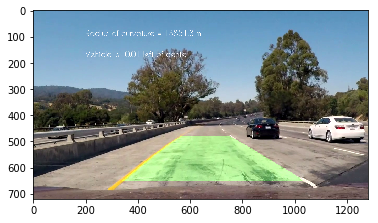

In [228]:
cap = cv2.VideoCapture('./project_video.mp4')

n = 0
x = 1000

while(cap.isOpened()):
    ret, frame = cap.read()
    n += 1
    if n < x:
        continue

    
    result = process_frame(frame)

#     print(result.shape)
    plt.imshow(result[..., ::-1])

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if n >= x:
        break

In [224]:
white_output = './project_video_sol.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
init()
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_sol.mp4
[MoviePy] Writing video ./project_video_sol.mp4



 12%|█▏        | 152/1261 [02:36<19:04,  1.03s/it]


 24%|██▍       | 303/1261 [05:11<16:23,  1.03s/it]


 36%|███▌      | 454/1261 [07:44<13:45,  1.02s/it]


 48%|████▊     | 605/1261 [10:18<11:10,  1.02s/it]


 60%|█████▉    | 756/1261 [12:54<08:37,  1.02s/it]


 72%|███████▏  | 907/1261 [15:34<06:04,  1.03s/it]


 84%|████████▍ | 1057/1261 [18:05<03:29,  1.03s/it]


 96%|█████████▌| 1205/1261 [20:26<00:56,  1.02s/it]


100%|█████████▉| 1260/1261 [21:18<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_sol.mp4 

CPU times: user 31min 5s, sys: 1min 40s, total: 32min 46s
Wall time: 21min 19s
